


# <h1><center>`Projet d'études sur le Big data Architecture`</center></h1>                        


.

In [1]:
import pyspark
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
from geopy.distance import distance
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
%matplotlib inline


spark = SparkSession.builder.master("local[*]") \
                    .appName('SparkSNCF') \
                    .getOrCreate()

sc = spark.sparkContext

print('Spark CPU usage :', sc.defaultParallelism)

Spark CPU usage : 4




## <h1><center>` 1. créer une fonction itineraryPrice (station1, station2) qui estimera le prix du trajet en 1ère classe entre les 2 noms de gares passés en paramètres `</center></h1>


* #### cette fonction devra utiliser PySpark pour exploiter les datasets choisis

* #### lister 4 résultats d'appels de cette fonction avec des gares différentes pour chaque appel


* #### la fonction devra retourner None dans le cas où :


     * les gares passés en paramètre n'existent pas    
     * le prix pour le trajet est inexistant



In [2]:
data_2 = sc.textFile("liste-des-gares.csv") \
        .map (lambda line: line.split(";")) \
        .map (lambda line: (line[1], line[13], line[14])) \
        .sortBy (lambda pair: pair[0], ascending = True)
        
        
data_2 = dict( data_2.map (lambda line: (line[0], [line[1], line[2]])).collect())
data_2

{'Abancourt': ['1.774718285053579', '49.68553371297622'],
 'Abbaretz': ['-1.524313466657773', '47.55546171193697'],
 'Abbeville': ['1.821026233063388', '50.10514547847399'],
 'Ablon': ['2.417931573714535', '48.72396312662991'],
 'Acheux-Franleu': ['1.657174350378938', '50.08247940983747'],
 'Achiet': ['2.780622102331761', '50.13214093061863'],
 'Achères-Grand-Cormier': ['2.092094579250713', '48.95528483926228'],
 'Achères-Ville': ['2.077781536261871', '48.970114458751645'],
 'Agay': ['6.856647145663769', '43.431591083348685'],
 'Agde': ['3.466954502196854', '43.31752183840884'],
 'Agen': ['0.621048372800292', '44.208341089900124'],
 'Agonac': ['0.748705624293986', '45.286590073064275'],
 'Aguilcourt-Variscourt': ['3.973514617883735', '49.40685314473819'],
 'Aiffres': ['-0.42144752662806', '46.28233694979594'],
 'Aigrefeuille-Le Thou': ['-0.952083708878203', '46.09393484633778'],
 'Aiguebelette-le-Lac': ['5.813156640721789', '45.53622016446212'],
 'Aiguebelle': ['6.306820208917644', '45

In [3]:
len(data_2)

3472

In [4]:
data_1 = sc.textFile("bareme-de-prix-national-ter.csv") \
        .map (lambda line: line.split(";")) \
        .map (lambda line: (line[0], line[1], line[2])) \
        .filter (lambda line: line[0] == "1 ère") \
        .sortBy (lambda pair: pair[1], ascending = True) 
        
        


data_1 = dict( data_1.map (lambda line: (line[1], line[2])).collect())
data_1

{'1': '1.8',
 '10': '4.1',
 '100': '26.7',
 '1000': '161.6',
 '101': '26.9',
 '1010': '162.8',
 '102': '27.2',
 '1020': '163.9',
 '103': '27.4',
 '1030': '165.0',
 '104': '27.6',
 '1040': '166.2',
 '105': '27.8',
 '1050': '167.3',
 '106': '28.1',
 '1060': '168.4',
 '107': '28.3',
 '1070': '169.6',
 '108': '28.5',
 '1080': '170.7',
 '109': '28.7',
 '1090': '171.8',
 '11': '4.4',
 '110': '29.7',
 '1100': '173.0',
 '111': '29.9',
 '1110': '174.1',
 '112': '30.1',
 '1120': '175.2',
 '113': '30.3',
 '1130': '176.4',
 '114': '30.5',
 '1140': '177.5',
 '115': '30.8',
 '1150': '178.6',
 '116': '31.0',
 '1160': '179.8',
 '117': '31.2',
 '1170': '180.9',
 '118': '31.4',
 '1180': '182.0',
 '119': '31.6',
 '1190': '183.2',
 '12': '4.7',
 '120': '31.8',
 '1200': '184.3',
 '121': '32.0',
 '1210': '185.4',
 '122': '32.3',
 '1220': '186.6',
 '123': '32.5',
 '1230': '187.7',
 '124': '32.7',
 '1240': '188.8',
 '125': '32.9',
 '1250': '190.0',
 '126': '33.1',
 '1260': '191.1',
 '127': '33.3',
 '1270': '1

##### <center><h1>`création de la fonction itineraryPrice (station1, station2)`</center></h1>




<center><h3> distance = R (π/2-arcsin(sin(latD)×sin(latO)+cos(longD-longO)×cos(latD)×cos(latO))) </center></h3>    
    
        


In [5]:
def itinerary_Price (station_1, station_2):

    Gares = sc.textFile("liste-des-gares.csv") \
            .map(lambda line: line.split(";")) \
            .map(lambda line: (line[1], line[13], line[14])) \
            .sortBy (lambda pair: pair[0], ascending = False)
    Gares = dict( Gares.map (lambda line: (line[0], [line[1], line[2]])).collect())
    
    prix = sc.textFile("bareme-de-prix-national-ter.csv") \
            .map (lambda line: line.split(";")) \
            .map (lambda line: (line[0], line[1], line[2])) \
            .filter (lambda line: line[0] == "1 ère") \
            .sortBy (lambda pair: pair[0], ascending = True) 

    prix = dict( prix.map (lambda line: (line[1], line[2])).collect())
    
    if station_1 not in Gares.keys():
        print ("None")
        return None
        
    elif station_2 not in Gares.keys():
        print ("None")
        return None
    
    
    for i in Gares.keys():
        if i == station_1:
            lon_1 = Gares[i][0] 
            lat_1 = Gares[i][1]
         
        
    for j in Gares.keys():
        if station_2 == j:
            lon_2 = Gares[j][0] 
            lat_2 = Gares[j][1]
        
        
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((float(lat_2) - float(lat_1)) * p)/2 + np.cos(float(lat_1) * p) * np.cos(float(lat_2) * p) * (1 - np.cos((float(lon_2) - float(lon_1)) * p)) / 2
    dist = 0.6213712 * 12742 * np.arcsin(np.sqrt(a))
    distance = int(dist)
    
    
    for k, v in (prix.items()):
        if k == str(distance):
            return (v)
        
    for k, v in (prix.items()):
        if k != str(distance):
            print ("None")
            return None

### 1. les gares passées en paramètre n'existent pas ("Dakar")

In [6]:
test = itinerary_Price ("dakar", "Agonac")
test


None


### 2. les gares passées en para et prix existent

In [7]:
test1 = itinerary_Price ("Amiens", "Abancourt")
test1



'9.5'

In [8]:
test_2 = itinerary_Price ("Aiguebelle", "Abancourt")
test_2

'75.4'

In [9]:
test_3 = itinerary_Price ("Cannes", "Abancourt")
test_3


'96.4'

In [10]:
test_ = itinerary_Price ("Cannes", "Aiffres")
test_

'83.7'

In [11]:
test_4 = itinerary_Price ("Clamart", "Béziers")
test_4

'79.4'

### 3. le prix pour le trajet est inexistant


In [12]:
test_5 = itinerary_Price ("Roppenheim", "Dirinon Loperhet")
test_5

None



# <h1><center>`2. Etablissez à l'aide du module python geopy un classement descendant des distances pour chaque trajets possible`</h1></center>




In [13]:
TGV = sc.textFile("tarifs-tgv-par-od.csv") \
            .map (lambda line: line.split(";")) \
            .map (lambda line: [i.split("-") for i in line]) \
            .map (lambda line: (line[0], line[3])) \
            .collect()
TGV = TGV[1:]
TGV = pd.DataFrame (TGV, columns = ["Origines", "Prix_1ere_classe"])
TGV["Origine"] = [i[0] for i in TGV["Origines"]]
TGV["Destinations"] = [i[1] for i in TGV["Origines"]]
TGV["Prix_1ere_classe"] = [str(i).strip('[]') for i in TGV["Prix_1ere_classe"]]
TGV = TGV.drop(columns=["Origines"])
order = [1,2,0] 
df = TGV[[TGV.columns[i] for i in order]]
df

,Origine,Destinations,Prix_1ere_classe
0,LILLE FLANDRES,AGDE,'188.0'
1,ARRAS,SETE,'188.0'
2,PERPIGNAN,TGV HAUTE PICARDIE,'188.0'
3,DOLE VILLE,PARIS MONTPARNASSE 1 ET 2,'106.0'
4,COLMAR,MACON VILLE,'90.0'
...,...,...,...
4157,MASSY TGV,NIORT,'126.0'
4158,LE MANS,DOL DE BRETAGNE,'62.0'
4159,LAVAL,PLOUARET TREGOR,'60.0'
4160,LIBOURNE,ST PIERRE DES CORPS,'78.0'


In [14]:
dataa = df[:250]

geolocator = Nominatim(user_agent="https")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

dataa["coord_origine"] = dataa["Origine"].apply(geocode).apply(lambda x: (x.latitude, x.longitude) 
                                                             if x!= None else None)
dataa["coord_destination"] = dataa["Destinations"].apply(geocode).apply(lambda x: (x.latitude, x.longitude) 
                                                                     if x!= None else None)

dataa["Distance"] = [int(geodesic(x, y).km) for x, y in zip(dataa['coord_origine'], dataa['coord_destination'])]
trajets_distances = (dataa.sort_values (by = "Distance", ascending = False)[["Origine", "Destinations", "Distance"]])

RateLimiter caught an error, retrying (0/2 tries). Called with (*('CLUSES  74',), **{}).
Traceback (most recent call last):
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 1347, in getresponse
    response.begin()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/manu/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File "/Users/m

RateLimiter swallowed an error after 2 retries. Called with (*('CLUSES  74',), **{}).
Traceback (most recent call last):
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 1347, in getresponse
    response.begin()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/manu/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File "/Users/manu

RateLimiter caught an error, retrying (1/2 tries). Called with (*('PARIS MONTPARNASSE 1 ET 2',), **{}).
Traceback (most recent call last):
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 1347, in getresponse
    response.begin()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/manu/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('PARIS MONTPARNASSE 1 ET 2 ',), **{}).
Traceback (most recent call last):
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 1347, in getresponse
    response.begin()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/manu/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)


RateLimiter swallowed an error after 2 retries. Called with (*('PARIS MONTPARNASSE 1 ET 2 ',), **{}).
Traceback (most recent call last):
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 1347, in getresponse
    response.begin()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/manu/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  F

RateLimiter caught an error, retrying (1/2 tries). Called with (*('PARIS MONTPARNASSE 1 ET 2',), **{}).
Traceback (most recent call last):
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 1347, in getresponse
    response.begin()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/manu/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('PARIS MONTPARNASSE 1 ET 2',), **{}).
Traceback (most recent call last):
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 1347, in getresponse
    response.begin()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/manu/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
 

RateLimiter swallowed an error after 2 retries. Called with (*('PARIS MONTPARNASSE 1 ET 2',), **{}).
Traceback (most recent call last):
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 1347, in getresponse
    response.begin()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/manu/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  Fi

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' PARIS MONTPARNASSE 1 ET 2',), **{}).
Traceback (most recent call last):
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 1347, in getresponse
    response.begin()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/manu/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)


RateLimiter caught an error, retrying (0/2 tries). Called with (*('PARIS MONTPARNASSE 1 ET 2',), **{}).
Traceback (most recent call last):
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 1347, in getresponse
    response.begin()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/manu/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
 

RateLimiter swallowed an error after 2 retries. Called with (*('PARIS MONTPARNASSE 1 ET 2',), **{}).
Traceback (most recent call last):
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 1347, in getresponse
    response.begin()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/manu/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  Fi

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' PARIS MONTPARNASSE 1 ET 2',), **{}).
Traceback (most recent call last):
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/manu/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 1347, in getresponse
    response.begin()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/manu/opt/anaconda3/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/manu/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)


<ipython-input-14-ff6482563c95>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataa["coord_destination"] = dataa["Destinations"].apply(geocode).apply(lambda x: (x.latitude, x.longitude)
<ipython-input-14-ff6482563c95>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataa["Distance"] = [int(geodesic(x, y).km) for x, y in zip(dataa['coord_origine'], dataa['coord_destination'])]


In [15]:
trajets_distances.head(60)

,Origine,Destinations,Distance
59,MARSEILLE BLANCARDE,ORANGE,9717
70,LA BAULE ESCOUBLAC,SABLE,7166
124,EVREUX EMBRANCHEMENT,AEROPORT CDG 2 TGV ROISSY,5432
97,paris austerlitz,Vendôme Gare TGV,5416
159,AEROPORT CDG2 TGV ROISSY,LANDERNEAU,5384
222,AEROPORT CDG 2 TGV ROISSY,ROSPORDEN,5326
160,AEROPORT CDG2 TGV ROISSY,ROSPORDEN,5326
158,PARIS MONTPARNASSE 1 ET 2,AURAY,5289
105,AEROPORT CDG 2 TGV ROISSY,REDON,5283
3,DOLE VILLE,PARIS MONTPARNASSE 1 ET 2,5245


-

    
# <h1><center>`3. Créer un Dataframe listant tous les trajets possibles avec 3 colonnes : Trajet, Distance, Prix en 1ère classe`</h1></center>    


-

In [16]:
trajets_distances_prix = dataa[["Origine", "Destinations", "Distance", "Prix_1ere_classe"]]
trajets_distances_prix = trajets_distances_prix.sort_values (by = "Distance", ascending = True)
trajets_distances_prix.head(60)

,Origine,Destinations,Distance,Prix_1ere_classe
126,CROIX WASQUEHAL,PARIS NORD,6,'82.0'
6,BELFORT,MONTBELIARD TGV,6,'66.0'
37,PORNICHET,ST NAZAIRE,9,'8.3'
36,ST JEAN DE MAURIENNE ARVAN,ST MICHEL VALLOIRE,11,'7.4'
197,MONACO MONTE CARLO,VENTIMIGLIA STAZIONE,16,'7.7'
45,MOUTIERS SALINS BRIDES,ALBERTVILLE,23,'16.0'
162,IRUN,BIARRITZ,24,'12.6'
164,BAYEUX,CAEN,26,'18.5'
39,MONTPELLIER,SETE,27,'13.2'
40,ANNEMASSE,THONON LES BAINS,27,'13.7'





# <center><h3> `4. Créer une représentation graphique mettant en avant la corrélation entre le prix et la distance pour chaque trajet possible`</center></h3>




### Piocher un certain nombre de données dans la base pour afficher clairement les données dans le graphe

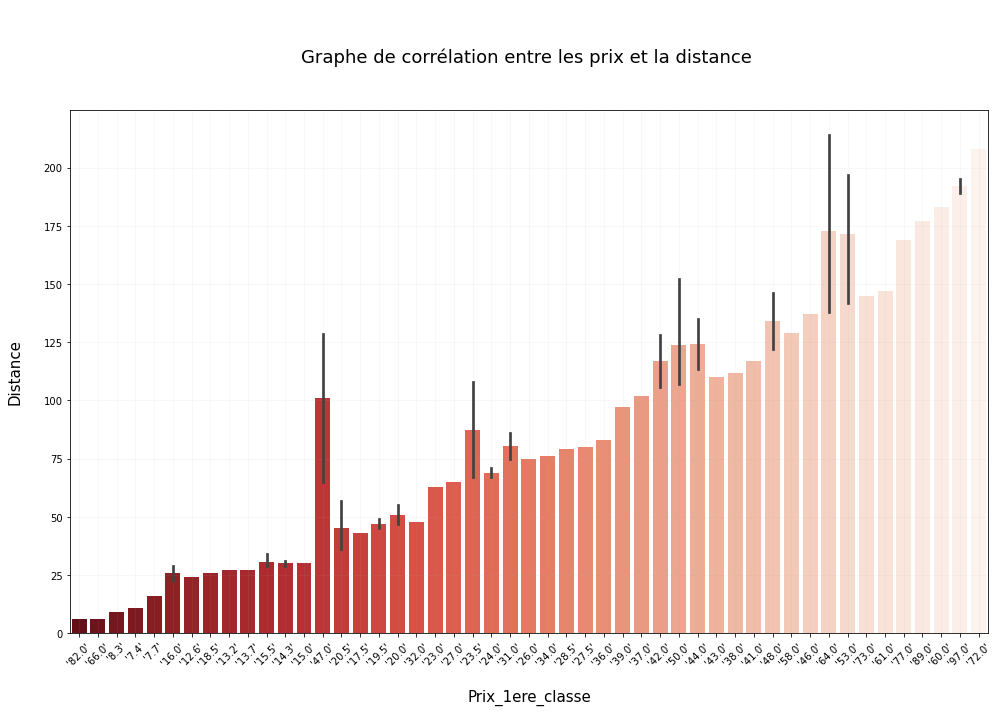

In [20]:
import seaborn as sns
plt.figure(figsize = (14,10))
sns.barplot(y = trajets_distances_prix['Distance'][:77], x = trajets_distances_prix["Prix_1ere_classe"][:77], palette="Reds_r")
plt.xlabel('\nPrix_1ere_classe', fontsize = 15, color = 'black')
plt.ylabel("Distance\n", fontsize = 15, color = 'black')
plt.title(" \n\nGraphe de corrélation entre les prix et la distance \n\n", fontsize = 18, color = 'black')
plt.xticks(rotation = 45)
#plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.grid(which = 'minor', alpha = 0.2)
plt.grid(which = 'major', alpha = 0.1)

plt.tight_layout()


Dans le cadre de l'exercice on voit bien que le prix en classe première n'est pas uniquement déterminé en fonction de la distance mais aussi en fonction de l'élasticité de la demande. 